# Job Shop Scheduling

## Contents

* [Background](#Background)
* [Job Shop Example](#JobShopExample)
* [Task Decomposition](#TaskDecomposition)
* [Model Formulation](#ModelFormulation)
* [Pyomo Implementation](#PyomoImplementation)
* [Displaying a Solution](#DisplayingSolution)
* [Visualzing Results using Gantt Charts](#Visualization)
* [Benchmark Problem LA19](#Benchmark)
* [Appication to Scheduling of Batch Processes](#BatchProcesses)
    * [Single Product Strategies](#SingleProduct)
    * [Overlapping Tasks](#OverlappingTasks)
    * [Unit Cleanout](#UnitCleanout)
    * [Zero-Wait Policy](#ZeroWait)

<a id="Background"></a>
## Background

A job shop consists of a set of distinct machines that process jobs. Each job is a series of tasks that require use of particular machines for known durations, and which must be completed in specified order. The job shop scheduling problem is to schedule the jobs on the machines to minimize the time necessary to process all jobs (i.e, the makespan) or some other metric of productivity. Job shop scheduling is one of the classic problems in Operations Research. 

Data consists of two tables. The first table is decomposition of the jobs into a series of tasks. Each task lists a job name, name of the required machine, and task duration. The second table list task pairs where the first task must be completed before the second task can be started. This formulation is quite general, but can also specify situations with no feasible solutions.  

<a id="JobShopExample"></a>
## Job Shop Example

The following example of a job shop is from from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Dash Optimization, 2000.

In this example, there are three printed paper products that must pass through color printing presses in a particular order. The given data consists of a flowsheet showing the order in which each job passes through the color presses

![jobshopdiagram.jpg](../../images/jobshopdiagram.jpg)

and a table of data showing, in minutes, the amount of time each job requires on each machine.

| Machine | Color | Paper 1 | Paper 2 | Paper 3 |
| :-----: | :---: | :-----: | :-----: | :-----: |
| 1       | Blue  | 45      | 20      | 12      |
| 2       | Green | -       | 10      | 17      |
| 3       | Yellow| 10      | 34      | 28      |

What is the minimum amount of time (i.e, what is the makespan) for this set of jobs?

<a id="TaskDecomposition"></a>
## Task Decomposition

The first step in the analysis is to decompose the process into a series of tasks. Each task is a (job,machine) pair. Some tasks cannot start until a prerequisite task is completed.

| Task (Job,Machine) | Duration | Prerequisite Task |
| :----------------: | :------: | :---------------: |
| (Paper 1, Blue)    | 45       | -                 |
| (Paper 1, Yellow)  | 10       | (Paper 1,Blue)    |
| (Paper 2, Blue)    | 20       | (Paper 2, Green)  |
| (Paper 2, Green)   | 10       | -                 |
| (Paper 2, Yellow)  | 34       | (Paper 2, Blue)   |
| (Paper 3, Blue)    | 12       | (Paper 3, Yellow) |
| (Paper 3, Green)   | 17       | (Paper 3, Blue)   |
| (Paper 3, Yellow)  | 28       | -                 |

We convert this to a JSON style representation where tasks are denoted by (Job,Machine) tuples in Python. The task data is stored in a Python dictionary indexed by (Job,Machine) tuples. The task data conists of a dictionary with duration ('dur') and (Job,Machine) pair for any prerequisite task.

In [1]:
TASKS = {
    ('Paper_1','Blue')   : {'dur': 45},
    ('Paper_1','Yellow') : {'dur': 10, 'prec': ('Paper_1','Blue')},
    ('Paper_2','Blue')   : {'dur': 20, 'prec': ('Paper_2','Green')},
    ('Paper_2','Green')  : {'dur': 10},
    ('Paper_2','Yellow') : {'dur': 34, 'prec': ('Paper_2','Blue')},
    ('Paper_3','Blue')   : {'dur': 12, 'prec': ('Paper_3','Yellow')},
    ('Paper_3','Green')  : {'dur': 17, 'prec': ('Paper_3','Blue')},
    ('Paper_3','Yellow') : {'dur': 28},   
}

<a id="ModelFormulation"></a>
## Model Formulation

Each task is represented as an ordered pair $(j,m)$ where $j$ is a job, and $m$ is a machine.

| Parameter | Description |
| :-------- | :-----------|
| $\text{dur}_{j,m}$ | Duration of task $(j,m)$ | 
| $\text{prec}_{j,m}$ | A task $(k,n) = \text{Prec}_{j,m}$ that must be completed before task $(j,m)$| 

| Decision Variables | Description |
| :-------- | :-----------|
| $\text{makespan}$  | Completion of all jobs | 
| $\text{start}_{j,m}$ | Start time for task $(j,m)$ |
| $y_{j,k,m}$ | boolean variable for tasks $(i,m)$ and $(j,m)$ on machine $m$ where $j < k$ |

Upper and lower bounds on the start and completion of task $(j,m)$

\begin{align}
\text{start}_{j,m} & \geq 0\\
\text{start}_{j,m}+\text{Dur}_{j,m} & \leq \text{makespan}
\end{align}

Satisfying prerequisite tasks

\begin{align}
\text{start}_{k,n}+\text{Dur}_{k,n}\leq\text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}
\end{align}

Disjunctive Constraints

If $M$ is big enough, then satisfying
\begin{align}
\text{start}_{j,m}+\text{Dur}_{j,m} & \leq \text{start}_{k,m}+M(1 - y_{j,k,m})\\
\text{start}_{k,m}+\text{Dur}_{k,m} & \leq \text{start}_{j,m}+My_{j,k,m}
\end{align}

avoids conflicts for use of the same machine. 

<a id="PyomoImplementation"></a>
## Pyomo Implementation

The job shop scheduling problem is implemented below in Pyomo. The implementation consists of of a function JobShop(TASKS) that accepts a dictionary of tanks and returns a pandas dataframe containing an optimal schedule of tasks. An optional argument to JobShop allows one to specify a solver.

In [2]:
from pyomo.environ import *
import pandas as pd

def JobShop(TASKS, solver='glpk'):

    model = ConcreteModel()

    JOBS = set()
    MACHINES = set()
    for (j,m) in TASKS.keys():
        JOBS.add(j)
        MACHINES.add(m)
        
    BigM = 1 + sum([TASKS[(j,m)]['dur'] for (j,m) in TASKS.keys()])
    
    model.start = Var(JOBS, MACHINES, domain = NonNegativeReals)
    model.makespan = Var(domain=NonNegativeReals)
    model.y = Var(JOBS,JOBS,MACHINES, domain = Boolean)

    model.Obj = Objective(expr = model.makespan, sense = minimize)

    model.cons = ConstraintList()
    for (j,m) in TASKS.keys():
        model.cons.add(model.start[j,m] + TASKS[(j,m)]['dur'] <= model.makespan)
        if 'prec' in TASKS[(j,m)]:
            (k,n) = TASKS[(j,m)]['prec']
            model.cons.add(model.start[j,m] >= model.start[k,n] + TASKS[(k,n)]['dur'])
        
    for m in MACHINES:
        for j in JOBS:
            for k in JOBS:
                if (j < k) and (j,m) in TASKS.keys() and (k,m) in TASKS.keys():
                    model.cons.add(model.start[j,m] + TASKS[(j,m)]['dur'] 
                                   <= model.start[k,m] + BigM*(1-model.y[j,k,m]))
                    model.cons.add(model.start[k,m] + TASKS[(k,m)]['dur'] 
                                   <= model.start[j,m] + BigM*(model.y[j,k,m]))

    # solve with indicated solver
    SolverFactory(solver).solve(model)
    
    # create pandas dataframe with the optimal schedule
    results = [[j,m,model.start[j,m](),TASKS[(j,m)]['dur'], model.start[j,m]() + TASKS[(j,m)]['dur']] 
             for (j,m) in TASKS]
    schedule = pd.DataFrame(results,columns=['Job','Machine','Start','Duration','Finish'])
    schedule = schedule.sort_values(by='Start')
    schedule.set_index(['Job',"Machine"], inplace=True)
    
    return schedule

In [3]:
schedule = JobShop(TASKS)

<a id="DisplayingSolution"></a>
## Displaying a Solution

In [4]:
def Textualize(schedule):
    
    JOBS = list(schedule.index.get_level_values('Job').unique())
    MACHINES = list(schedule.index.get_level_values('Machine').unique())

    print('\nJOB SCHEDULES\n')
    for j in sorted(JOBS):
        print("Job: " + j)
        print(schedule.xs(j,level=0))
        print('')
        
    print('\nMACHINE SCHEDULES\n')
    for m in MACHINES:
        print("Machine: " + m)
        print(schedule.xs(m,level=1))
        print('')

Textualize(schedule)


JOB SCHEDULES

Job: Paper_1
         Start  Duration  Finish
Machine                         
Blue      42.0        45    87.0
Yellow    87.0        10    97.0

Job: Paper_2
         Start  Duration  Finish
Machine                         
Green      0.0        10    10.0
Blue      10.0        20    30.0
Yellow    53.0        34    87.0

Job: Paper_3
         Start  Duration  Finish
Machine                         
Yellow     0.0        28    28.0
Blue      30.0        12    42.0
Green     42.0        17    59.0


MACHINE SCHEDULES

Machine: Green
         Start  Duration  Finish
Job                             
Paper_2    0.0        10    10.0
Paper_3   42.0        17    59.0

Machine: Yellow
         Start  Duration  Finish
Job                             
Paper_3    0.0        28    28.0
Paper_2   53.0        34    87.0
Paper_1   87.0        10    97.0

Machine: Blue
         Start  Duration  Finish
Job                             
Paper_2   10.0        20    30.0
Paper_3   30.0   

<a id="Visualization"></a>
## Visualizing Results with Gantt Charts

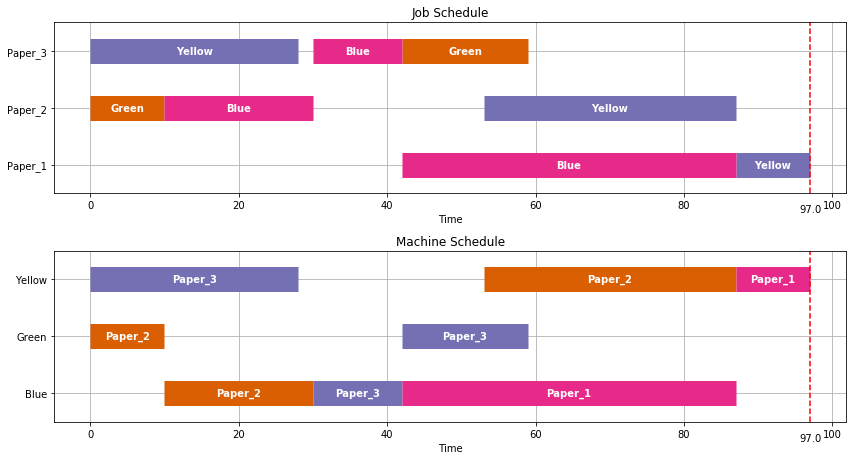

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def Visualize(schedule):
    
    JOBS = list(schedule.index.get_level_values('Job').unique())
    MACHINES = list(schedule.index.get_level_values('Machine').unique())
    makespan = schedule['Finish'].max()

    plt.figure(figsize=(12, 5 + (len(JOBS)+len(MACHINES))/4))
    plt.subplot(2,1,1)

    jdx = 0
    for j in sorted(JOBS):
        jdx += 1
        mdx = 0
        for m in MACHINES:
            mdx += 1
            c = mpl.cm.Dark2.colors[mdx%7]
            if (j,m) in schedule.index:
                plt.plot([schedule.loc[(j,m),'Start'],schedule.loc[(j,m),'Finish']],
                     [jdx,jdx],color = c,alpha=1.0,lw=25,solid_capstyle='butt')
                plt.text((schedule.loc[(j,m),'Start'] + schedule.loc[(j,m),'Finish'])/2.0,jdx,
                    m, color='white', weight='bold',
                    horizontalalignment='center', verticalalignment='center')
    
    plt.ylim(0.5,jdx+0.5)
    plt.title('Job Schedule')
    plt.gca().set_yticks(range(1,1+len(JOBS)))
    plt.gca().set_yticklabels(sorted(JOBS))
    plt.plot([makespan,makespan],plt.ylim(),'r--')
    plt.text(makespan,plt.ylim()[0]-0.2,str(round(makespan,2)),
            horizontalalignment='center', verticalalignment='top')
    plt.xlabel('Time')
    plt.grid()
    
    plt.subplot(2,1,2)
    mdx = 0
    for m in sorted(MACHINES):
        mdx += 1
        jdx = 0
        for j in JOBS:
            jdx += 1
            c = mpl.cm.Dark2.colors[jdx%7]
            if (j,m) in schedule.index:
                plt.plot([schedule.loc[(j,m),'Start'],schedule.loc[(j,m),'Finish']],
                     [mdx,mdx],color = c,alpha=1.0,lw=25,solid_capstyle='butt')
                plt.text((schedule.loc[(j,m),'Start'] + schedule.loc[(j,m),'Finish'])/2.0,mdx,
                    j, color='white', weight='bold',
                    horizontalalignment='center', verticalalignment='center')

    plt.ylim(0.5,mdx+0.5)
    plt.title('Machine Schedule')
    plt.gca().set_yticks(range(1,1+len(MACHINES)))
    plt.gca().set_yticklabels(sorted(MACHINES))
    plt.plot([makespan,makespan],plt.ylim(),'r--')
    plt.text(makespan,plt.ylim()[0]-0.2,str(round(makespan,2)),
            horizontalalignment='center', verticalalignment='top')
    plt.xlabel('Time')
    plt.grid()
    
    plt.tight_layout()

Visualize(schedule)

<a id="Benchmark"></a>
## Benchmark Problem LA19

LA19 is a benchmark problem for job shop scheduling introduced by Lawrence in 1984, and a solution presented by Cook and Applegate in 1991. The following cell may take many minutes to several hours to run, depending on the choice of solver and hardware.

In [6]:
data = """
2  44  3   5  5  58  4  97  0   9  7  84  8  77  9  96  1  58  6  89
4  15  7  31  1  87  8  57  0  77  3  85  2  81  5  39  9  73  6  21
9  82  6  22  4  10  3  70  1  49  0  40  8  34  2  48  7  80  5  71
1  91  2  17  7  62  5  75  8  47  4  11  3   7  6  72  9  35  0  55
6  71  1  90  3  75  0  64  2  94  8  15  4  12  7  67  9  20  5  50
7  70  5  93  8  77  2  29  4  58  6  93  3  68  1  57  9   7  0  52
6  87  1  63  4  26  5   6  2  82  3  27  7  56  8  48  9  36  0  95
0  36  5  15  8  41  9  78  3  76  6  84  4  30  7  76  2  36  1   8
5  88  2  81  3  13  6  82  4  54  7  13  8  29  9  40  1  78  0  75
9  88  4  54  6  64  7  32  0  52  2   6  8  54  5  82  3   6  1  26
"""

TASKS = {}
prec = ''

lines = data.splitlines()
job= 0
for line in lines[1:]:
    j = "J{0:1d}".format(job)
    nums = line.split()
    prec = ''
    for m,dur in zip(nums[::2],nums[1::2]):
        task = (j,'M{0:s}'.format(m))
        if prec:
            TASKS[task] = {'dur':int(dur), 'prec':prec}
        else:
            TASKS[task] = {'dur':int(dur)}
        prec = task
    job += 1
    
#Visualize(JobShop(TASKS, solver='cbc'))

<a id="BatchProcesses"></a>
## Application to Scheduling of Batch Processes

We will now turn our attention to the application of the job shop scheduling problem to the short term scheduling of batch processes. We illustrate these techniques using an example from Dunn (2013).

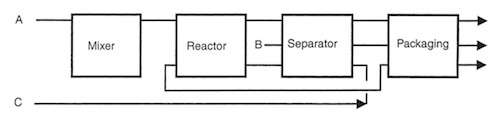

| Process | Mixer | Reactor | Separator | Packaging |
| :-----: | :---: | :-----: | :-------: | :-------: |
| A       | 1.0   | 5.0     | 4.0       | 1.5       |
| B       | -     | -       | 4.5       | 1.0       |
| C       | -     | 3.0     | 5.0       | 1.5       |

<a id="SingleProduct"></a>
## Single Product Strategies

Before going further, we create a function to streamline the generation of T

In [7]:
def Recipe(jobs,machines,durations):
    TASKS = {}
    for j in jobs:
        prec = (None,None)
        for m,d in zip(machines,durations):
            task = (j,m)
            if prec == (None,None):
                TASKS.update({(j,m): {'dur': d}})
            else:
                TASKS.update({(j,m): {'dur': d, 'prec': prec}})
            prec = task
    return TASKS
        
RecipeA = Recipe('A',['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
RecipeB = Recipe('B',['Separator','Packaging'],[4.5,1])
RecipeC = Recipe('C',['Separator','Reactor','Packaging'],[5,3,1.5])

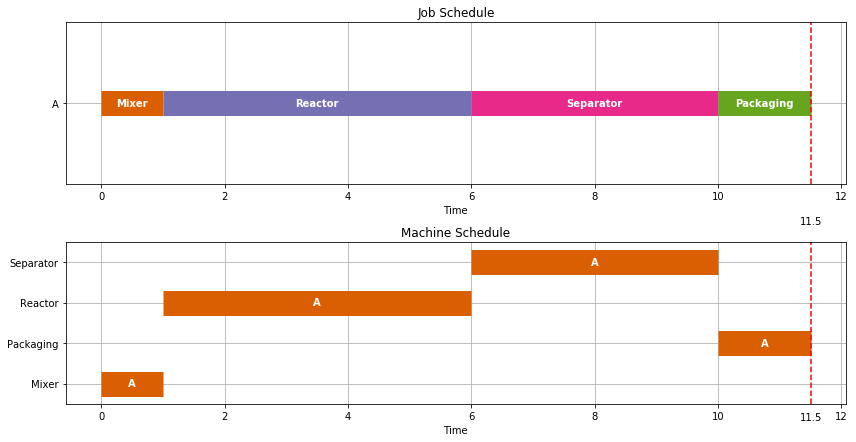

In [8]:
Visualize(JobShop(RecipeA))

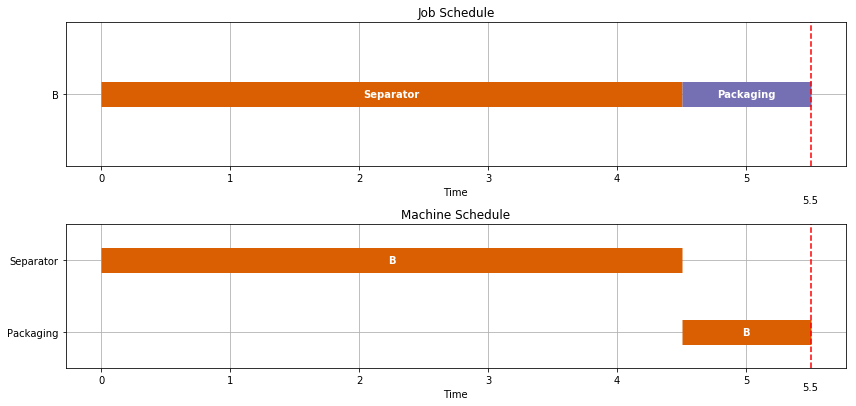

In [9]:
Visualize(JobShop(RecipeB))

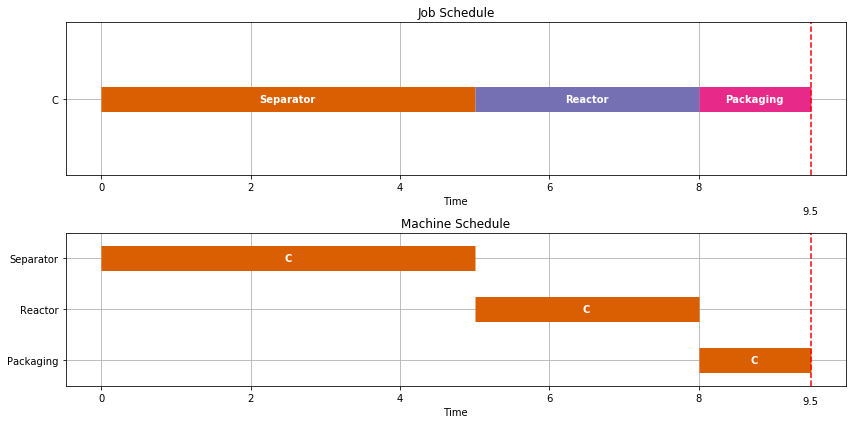

In [10]:
Visualize(JobShop(RecipeC))

<a id="OverlappingTasks"></a>
## Overlapping Tasks

Let's now consider an optimal scheduling problem where we are wish to make two batches of Product A.

16.5


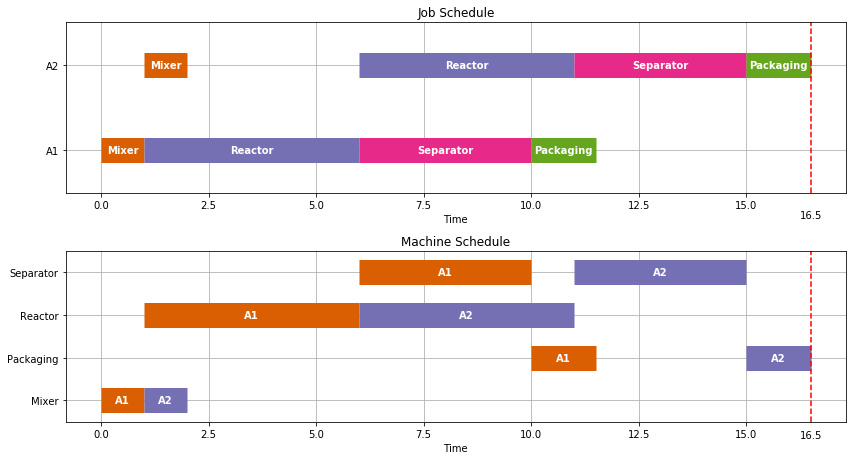

In [11]:
TASKS = Recipe(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
schedule = JobShop(TASKS,solver='glpk')
Visualize(schedule)
print(schedule['Finish'].max())

Earlier we found it tood 11.5 hours to produce one batch of product A.  As we see here, we can produce a second batch with only 5.0 additional hours because some of the tasks overlap.  The overlapping of tasks is the key to gaining efficiency in batch processing facilities.

Let's next consider production of a single batch each of products A, B, and C.

15.0


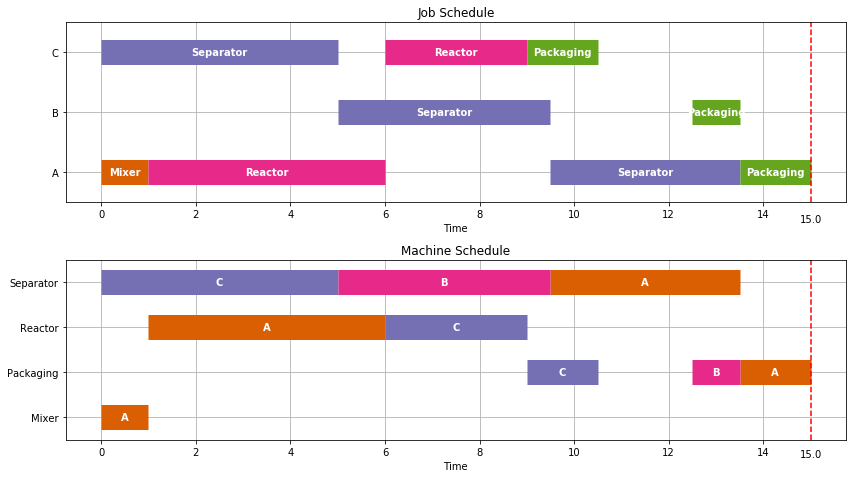

In [12]:
TASKS = RecipeA
TASKS.update(RecipeB)
TASKS.update(RecipeC)

schedule = JobShop(TASKS,solver='glpk')
Visualize(schedule)
print(schedule['Finish'].max())

The individual production of A, B, and C required 11.5, 5.5, and 9.5 hours, respectively, for a total of 25.5 hours. As we see here, by scheduling the production simultaneously, we can get all three batches done in just 15 hours. 

As we see below, each additional set of three products takes an additionl 13 hours.  So there is considerable efficiency gained by scheduling over longer intervals whenever possible.

28.0


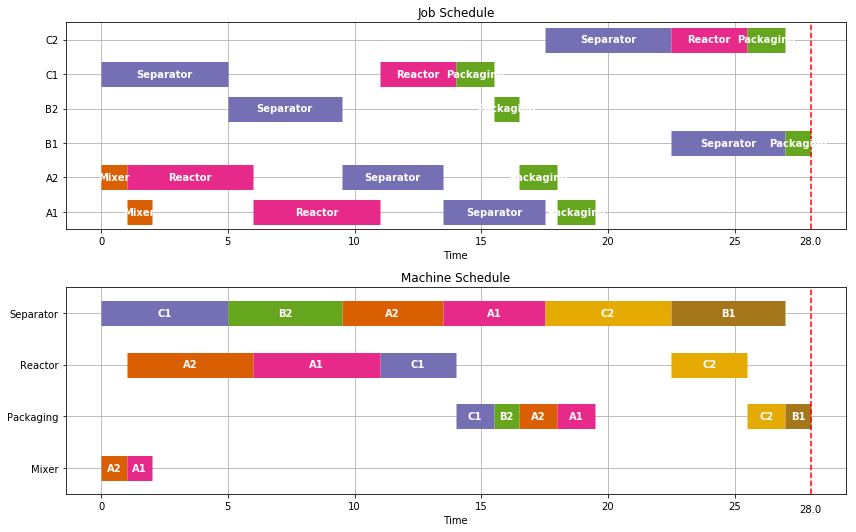

In [13]:
TASKS = Recipe(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
TASKS.update(Recipe(['B1','B2'],['Separator','Packaging'],[4.5,1]))
TASKS.update(Recipe(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

schedule = JobShop(TASKS,solver='glpk')
Visualize(schedule)
print(schedule['Finish'].max())

<a id="UnitCleanout"></a>
## Unit Cleanout

A common feature in batch unit operations is a requirement that equipment be cleaned prior to reuse. 

In most cases the time needed for clean out would be equipment and product specific. Bur for the purposes of illustration, we implement this policy with a single non-negative parameter $t_{clean} \geq 0$ which, if specified, requires a period no less than $t_{clean}$ between the finish of one task and the start of another on every piece of equipment.

This is implemented by modifying the usual disjunctive constraints to avoid machine conflicts, i.e.,

\begin{align}
\text{start}_{j,m}+\text{Dur}_{j,m} & \leq \text{start}_{k,m}+M(1 - y_{j,k,m})\\
\text{start}_{k,m}+\text{Dur}_{k,m} & \leq \text{start}_{j,m}+My_{j,k,m}
\end{align}

to read

\begin{align}
\text{start}_{j,m}+\text{Dur}_{j,m} + t_{clean} & \leq \text{start}_{k,m}+M(1 - y_{j,k,m})\\
\text{start}_{k,m}+\text{Dur}_{k,m} + t_{clean} & \leq \text{start}_{j,m}+My_{j,k,m}
\end{align}

for sufficiently large $M$.

Makespan =  30.5


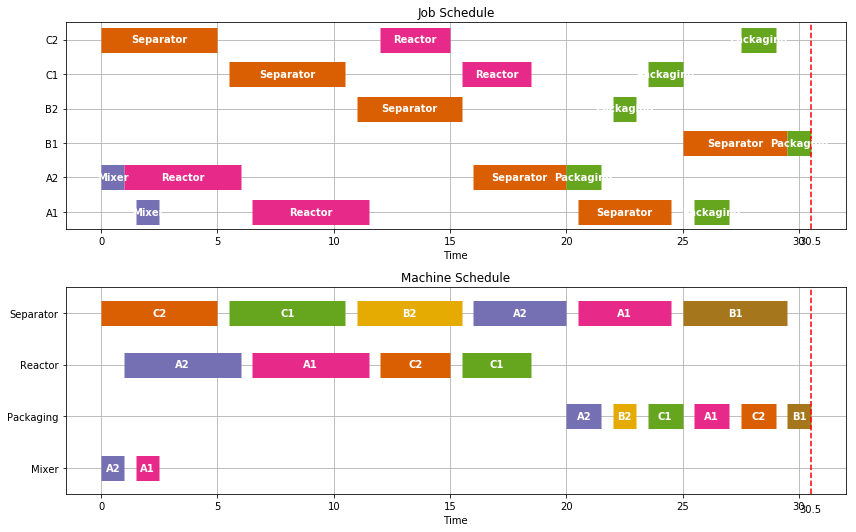

In [14]:
from pyomo.environ import *
import pandas as pd

def JobShop(TASKS, solver='glpk', tclean = 0):

    model = ConcreteModel()

    JOBS = set()
    MACHINES = set()
    for (j,m) in TASKS.keys():
        JOBS.add(j)
        MACHINES.add(m)
        
    BigM = 1 + sum([TASKS[(j,m)]['dur'] for (j,m) in TASKS.keys()])
    
    model.start = Var(JOBS, MACHINES, domain = NonNegativeReals)
    model.makespan = Var(domain=NonNegativeReals)
    model.y = Var(JOBS,JOBS,MACHINES, domain = Boolean)

    model.Obj = Objective(expr = model.makespan, sense = minimize)

    model.cons = ConstraintList()
    for (j,m) in TASKS.keys():
        model.cons.add(model.start[j,m] + TASKS[(j,m)]['dur'] + tclean <= model.makespan)
        if 'prec' in TASKS[(j,m)]:
            (k,n) = TASKS[(j,m)]['prec']
            model.cons.add(model.start[j,m] >= model.start[k,n] + TASKS[(k,n)]['dur'])
        
    for m in MACHINES:
        for j in JOBS:
            for k in JOBS:
                if (j < k) and (j,m) in TASKS.keys() and (k,m) in TASKS.keys():
                    model.cons.add(model.start[j,m] + TASKS[(j,m)]['dur'] + tclean
                                   <= model.start[k,m] + BigM*(1-model.y[j,k,m]))
                    model.cons.add(model.start[k,m] + TASKS[(k,m)]['dur']  + tclean
                                   <= model.start[j,m] + BigM*(model.y[j,k,m]))

    # solve with indicated solver
    SolverFactory(solver).solve(model)
    
    # create pandas dataframe with the optimal schedule
    results = [[j,m,model.start[j,m](),TASKS[(j,m)]['dur'], model.start[j,m]() + TASKS[(j,m)]['dur']] 
             for (j,m) in TASKS]
    schedule = pd.DataFrame(results,columns=['Job','Machine','Start','Duration','Finish'])
    schedule = schedule.sort_values(by='Start')
    schedule.set_index(['Job',"Machine"], inplace=True)
    
    return schedule


TASKS = Recipe(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
TASKS.update(Recipe(['B1','B2'],['Separator','Packaging'],[4.5,1]))
TASKS.update(Recipe(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

schedule = JobShop(TASKS, solver='glpk', tclean=0.5)
Visualize(schedule)
print("Makespan = ", schedule['Finish'].max())

<a id="ZeroWait"></a>
## Zero Wait Policy

One of the issues in the use of job shop scheduling for batch processing are situations where there it isn't possible to store intermediate materials. If there is no way to store intermediates, either in the processing equipment or in external vessels, then a **zero-wait** policy may be appropriate. 

A zero-wait policy requires subsequent processing machines to be available immediately upon completion of any task. To implement this policy, the usual precident sequencing constraint of a job shop scheduling problem, i.e.,

\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} \leq \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}
\end{align*}

is changed to 

\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} = \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}\text{ and ZW is True}
\end{align*}

if the zero-wait policy is in effect. 

While this could be implemented on an equipment or product specific basis, here we add an optional ZW flag to the JobShop function that, by default, is set to False.

Makespan =  32.0


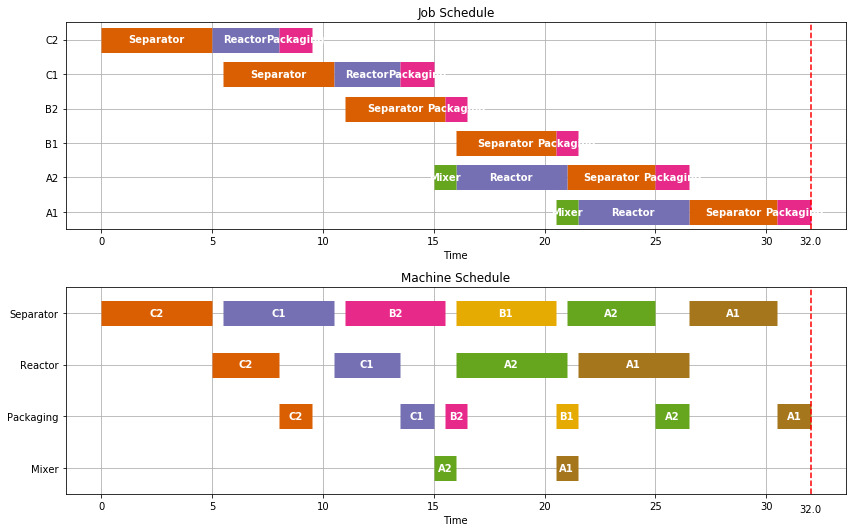

In [15]:
from pyomo.environ import *
import pandas as pd

def JobShop(TASKS, solver='glpk', tclean = 0, ZW = False):

    model = ConcreteModel()

    JOBS = set()
    MACHINES = set()
    for (j,m) in TASKS.keys():
        JOBS.add(j)
        MACHINES.add(m)
        
    BigM = 1 + sum([TASKS[(j,m)]['dur'] for (j,m) in TASKS.keys()])
    
    model.start = Var(JOBS, MACHINES, domain = NonNegativeReals)
    model.makespan = Var(domain=NonNegativeReals)
    model.y = Var(JOBS,JOBS,MACHINES, domain = Boolean)

    model.Obj = Objective(expr = model.makespan, sense = minimize)

    model.cons = ConstraintList()
    for (j,m) in TASKS.keys():
        model.cons.add(model.start[j,m] + TASKS[(j,m)]['dur'] + tclean <= model.makespan)
        if 'prec' in TASKS[(j,m)]:
            (k,n) = TASKS[(j,m)]['prec']
            if ZW:
                model.cons.add(model.start[j,m] == model.start[k,n] + TASKS[(k,n)]['dur'])
            else:
                model.cons.add(model.start[j,m] >= model.start[k,n] + TASKS[(k,n)]['dur'])
        
    for m in MACHINES:
        for j in JOBS:
            for k in JOBS:
                if (j < k) and (j,m) in TASKS.keys() and (k,m) in TASKS.keys():
                    model.cons.add(model.start[j,m] + TASKS[(j,m)]['dur'] + tclean
                                   <= model.start[k,m] + BigM*(1-model.y[j,k,m]))
                    model.cons.add(model.start[k,m] + TASKS[(k,m)]['dur']  + tclean
                                   <= model.start[j,m] + BigM*(model.y[j,k,m]))

    # solve with indicated solver
    SolverFactory(solver).solve(model)
    
    # create pandas dataframe with the optimal schedule
    results = [[j,m,model.start[j,m](),TASKS[(j,m)]['dur'], model.start[j,m]() + TASKS[(j,m)]['dur']] 
             for (j,m) in TASKS]
    schedule = pd.DataFrame(results,columns=['Job','Machine','Start','Duration','Finish'])
    schedule = schedule.sort_values(by='Start')
    schedule.set_index(['Job',"Machine"], inplace=True)
    
    return schedule

TASKS = Recipe(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
TASKS.update(Recipe(['B1','B2'],['Separator','Packaging'],[4.5,1]))
TASKS.update(Recipe(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

schedule = JobShop(TASKS, solver='glpk', tclean=0.5, ZW=True)
Visualize(schedule)
print("Makespan = ", schedule['Finish'].max())